# 👾 PixelCNN from scratch

In this notebook, we'll walk through the steps required to train your own PixelCNN on the fashion MNIST dataset from scratch

## Table of contents
0. [Parameters](#parameters)
1. [Prepare the Data](#prepare)
2. [Build the PixelCNN](#build)
3. [Train the PixelCNN](#train)
4. [Generate images](#generate)

In [45]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [46]:
import numpy as np
import matplotlib.pyplot as plt
import os

import tensorflow as tf
from tensorflow import keras

import absl.logging

absl.logging.set_verbosity(absl.logging.ERROR)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

from skimage.transform import resize

from utils.image import display

## 0. Parameters <a name="parameters"></a>

In [57]:
IMAGE_SIZE = 16
PIXEL_LEVELS = 4
N_FILTERS = 128
RESIDUAL_BLOCKS = 5
BATCH_SIZE = 128
EPOCHS = 150

## 1. Prepare the data <a name="prepare"></a>

In [58]:
# Load the data
(x_train, _), (_, _) = keras.datasets.fashion_mnist.load_data()

In [59]:
# Preprocess the data
def preprocess(imgs_int):
    imgs_int = np.expand_dims(imgs_int, -1)
    imgs_int = tf.image.resize(imgs_int, (IMAGE_SIZE, IMAGE_SIZE)).numpy()
    imgs_int = (imgs_int / (256 / PIXEL_LEVELS)).astype(int)
    imgs = imgs_int.astype("float32")
    imgs = imgs / PIXEL_LEVELS
    return imgs, imgs_int


input_data, output_data = preprocess(x_train)

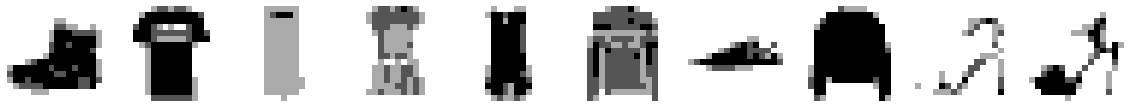

In [60]:
# Show some items of clothing from the training set
display(input_data)

## 2. Build the PixelCNN

In [61]:
# The first layer is the PixelCNN layer. This layer simply
# builds on the 2D convolutional layer, but includes masking.
class MaskedConv2D(keras.layers.Layer):
    def __init__(self, mask_type, **kwargs):
        super(MaskedConv2D, self).__init__()
        self.mask_type = mask_type
        self.conv = keras.layers.Conv2D(**kwargs)

    def build(self, input_shape):
        # Build the conv2d layer to initialize kernel variables
        self.conv.build(input_shape)
        # Use the initialized kernel to create the mask
        kernel_shape = self.conv.kernel.get_shape()
        self.mask = np.zeros(shape=kernel_shape)
        self.mask[: kernel_shape[0] // 2, ...] = 1.0
        self.mask[kernel_shape[0] // 2, : kernel_shape[1] // 2, ...] = 1.0
        if self.mask_type == "B":
            self.mask[kernel_shape[0] // 2, kernel_shape[1] // 2, ...] = 1.0

    def call(self, inputs):
        self.conv.kernel.assign(self.conv.kernel * self.mask)
        return self.conv(inputs)

    def get_config(self):
        cfg = super().get_config()
        return cfg

In [62]:
class ResidualBlock(keras.layers.Layer):
    def __init__(self, filters, **kwargs):
        super(ResidualBlock, self).__init__(**kwargs)
        self.conv1 = keras.layers.Conv2D(filters=filters // 2, kernel_size=1, activation="relu")
        self.pixel_conv = MaskedConv2D(
            mask_type="B",
            filters=filters // 2,
            kernel_size=3,
            activation="relu",
            padding="same",
        )
        self.conv2 = keras.layers.Conv2D(filters=filters, kernel_size=1, activation="relu")

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.pixel_conv(x)
        x = self.conv2(x)
        return keras.layers.add([inputs, x])

    def get_config(self):
        cfg = super().get_config()
        return cfg

In [63]:
inputs = keras.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 1))
x = MaskedConv2D(mask_type="A", filters=N_FILTERS, kernel_size=7, activation="relu", padding="same")(inputs)

for _ in range(RESIDUAL_BLOCKS):
    x = ResidualBlock(filters=N_FILTERS)(x)

for _ in range(2):
    x = MaskedConv2D(
        mask_type="B",
        filters=N_FILTERS,
        kernel_size=1,
        strides=1,
        activation="relu",
        padding="valid",
    )(x)

out = keras.layers.Conv2D(filters=PIXEL_LEVELS, kernel_size=1, strides=1, activation="softmax", padding="valid")(x)

pixel_cnn = keras.Model(inputs, out)
pixel_cnn.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 16, 16, 1)]       0         
                                                                 
 pixel_conv_layer_8 (PixelCo  (None, 16, 16, 128)      6400      
 nvLayer)                                                        
                                                                 
 residual_block_5 (ResidualB  (None, 16, 16, 128)      53504     
 lock)                                                           
                                                                 
 residual_block_6 (ResidualB  (None, 16, 16, 128)      53504     
 lock)                                                           
                                                                 
 residual_block_7 (ResidualB  (None, 16, 16, 128)      53504     
 lock)                                                     

## 3. Train the PixelCNN <a name="train"></a>

In [64]:
adam = keras.optimizers.Adam(learning_rate=0.0005)
pixel_cnn.compile(optimizer=adam, loss="sparse_categorical_crossentropy")

In [65]:
tensorboard_callback = keras.callbacks.TensorBoard(log_dir="./logs")


class ImageGenerator(keras.callbacks.Callback):
    def __init__(self, num_img):
        self.num_img = num_img

    def sample_from(self, probs, temperature):  # <2>
        probs = probs ** (1 / temperature)
        probs = probs / np.sum(probs)
        return np.random.choice(len(probs), p=probs)

    def generate(self, temperature):
        generated_images = np.zeros(shape=(self.num_img,) + (pixel_cnn.input_shape)[1:])
        batch, rows, cols, channels = generated_images.shape

        for row in range(rows):
            for col in range(cols):
                for channel in range(channels):
                    probs = self.model.predict(generated_images)[:, row, col, :]
                    generated_images[:, row, col, channel] = [self.sample_from(x, temperature) for x in probs]
                    generated_images[:, row, col, channel] /= PIXEL_LEVELS

        return generated_images

    def on_epoch_end(self, epoch, logs=None):
        generated_images = self.generate(temperature=1.0)
        display(generated_images, save_to="./output/generated_img_%03d.png" % (epoch))


img_generator_callback = ImageGenerator(num_img=10)

Epoch 1/150
469/469 [==============================] - ETA: 0s - loss: 0.4869
Saved to ./output/generated_img_000.png


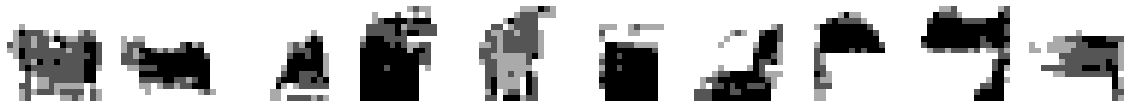

469/469 [==============================] - 27s 56ms/step - loss: 0.4869
Epoch 2/150
469/469 [==============================] - ETA: 0s - loss: 0.3990
Saved to ./output/generated_img_001.png


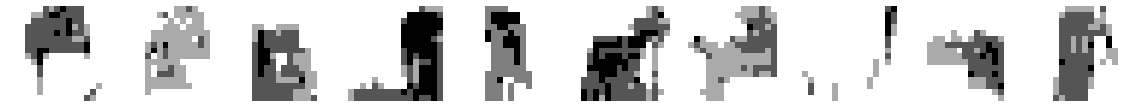

469/469 [==============================] - 27s 57ms/step - loss: 0.3990
Epoch 3/150
469/469 [==============================] - ETA: 0s - loss: 0.3860
Saved to ./output/generated_img_002.png


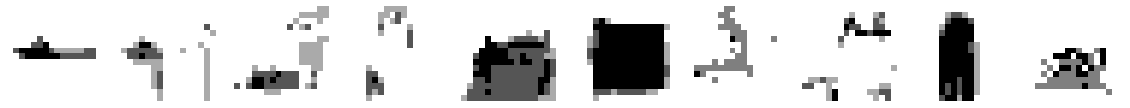

469/469 [==============================] - 26s 56ms/step - loss: 0.3860
Epoch 4/150
469/469 [==============================] - ETA: 0s - loss: 0.3793
Saved to ./output/generated_img_003.png


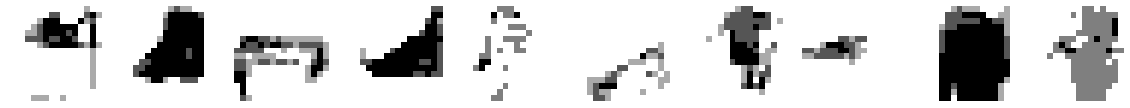

469/469 [==============================] - 28s 59ms/step - loss: 0.3793
Epoch 5/150
469/469 [==============================] - ETA: 0s - loss: 0.3757
Saved to ./output/generated_img_004.png


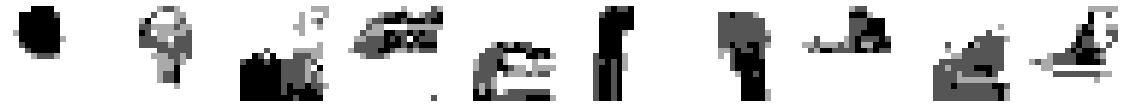

469/469 [==============================] - 26s 56ms/step - loss: 0.3757
Epoch 6/150
468/469 [============================>.] - ETA: 0s - loss: 0.3721
Saved to ./output/generated_img_005.png


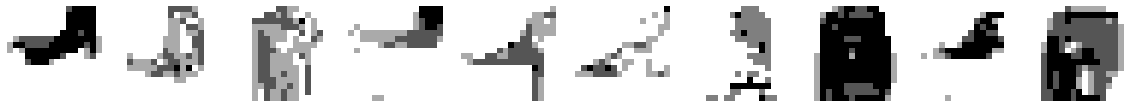

469/469 [==============================] - 28s 59ms/step - loss: 0.3721
Epoch 7/150
468/469 [============================>.] - ETA: 0s - loss: 0.3692
Saved to ./output/generated_img_006.png


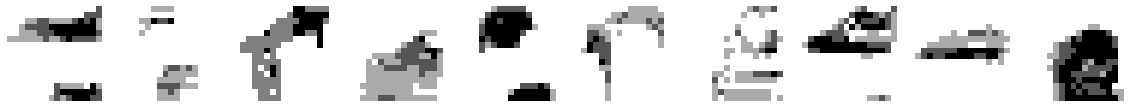

469/469 [==============================] - 27s 57ms/step - loss: 0.3692
Epoch 8/150
469/469 [==============================] - ETA: 0s - loss: 0.3674
Saved to ./output/generated_img_007.png


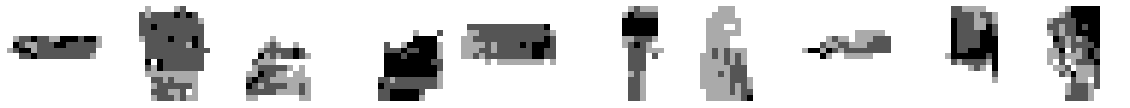

469/469 [==============================] - 26s 56ms/step - loss: 0.3674
Epoch 9/150
469/469 [==============================] - ETA: 0s - loss: 0.3644
Saved to ./output/generated_img_008.png


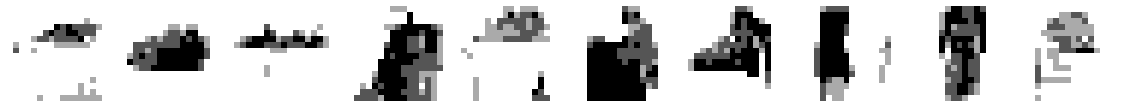

469/469 [==============================] - 26s 56ms/step - loss: 0.3644
Epoch 10/150
469/469 [==============================] - ETA: 0s - loss: 0.3627
Saved to ./output/generated_img_009.png


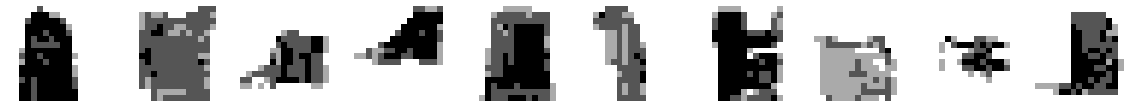

469/469 [==============================] - 26s 56ms/step - loss: 0.3627
Epoch 11/150
469/469 [==============================] - ETA: 0s - loss: 0.3601
Saved to ./output/generated_img_010.png


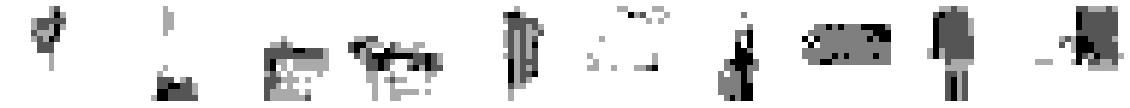

469/469 [==============================] - 27s 57ms/step - loss: 0.3601
Epoch 12/150
469/469 [==============================] - ETA: 0s - loss: 0.3579
Saved to ./output/generated_img_011.png


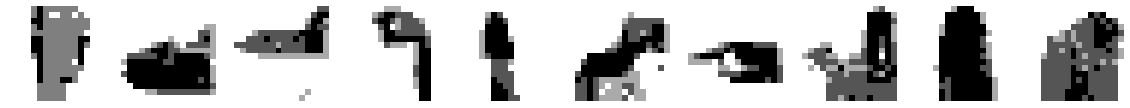

469/469 [==============================] - 26s 56ms/step - loss: 0.3579
Epoch 13/150
469/469 [==============================] - ETA: 0s - loss: 0.3566
Saved to ./output/generated_img_012.png


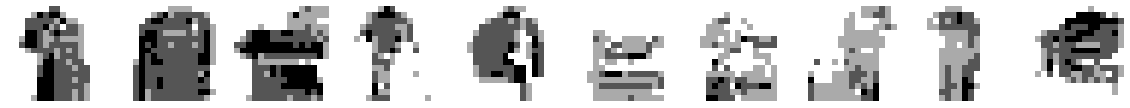

469/469 [==============================] - 28s 59ms/step - loss: 0.3566
Epoch 14/150
469/469 [==============================] - ETA: 0s - loss: 0.3550
Saved to ./output/generated_img_013.png


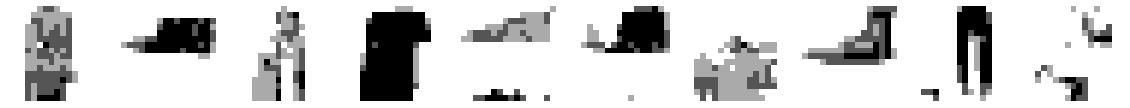

469/469 [==============================] - 26s 56ms/step - loss: 0.3550
Epoch 15/150
469/469 [==============================] - ETA: 0s - loss: 0.3536
Saved to ./output/generated_img_014.png


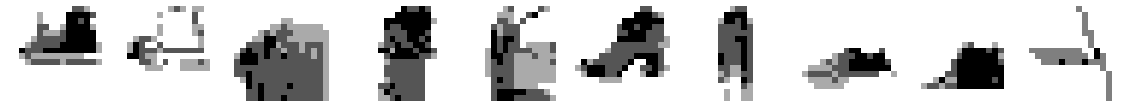

469/469 [==============================] - 28s 60ms/step - loss: 0.3536
Epoch 16/150
469/469 [==============================] - ETA: 0s - loss: 0.3526
Saved to ./output/generated_img_015.png


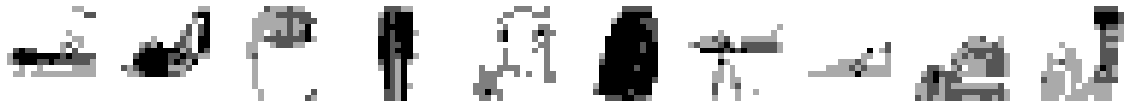

469/469 [==============================] - 26s 56ms/step - loss: 0.3526
Epoch 17/150
469/469 [==============================] - ETA: 0s - loss: 0.3514
Saved to ./output/generated_img_016.png


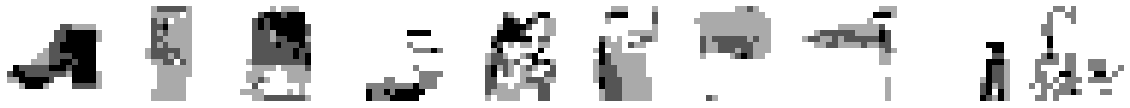

469/469 [==============================] - 26s 56ms/step - loss: 0.3514
Epoch 18/150
469/469 [==============================] - ETA: 0s - loss: 0.3503
Saved to ./output/generated_img_017.png


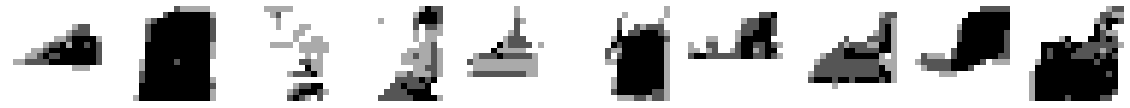

469/469 [==============================] - 27s 57ms/step - loss: 0.3503
Epoch 19/150
469/469 [==============================] - ETA: 0s - loss: 0.3492
Saved to ./output/generated_img_018.png


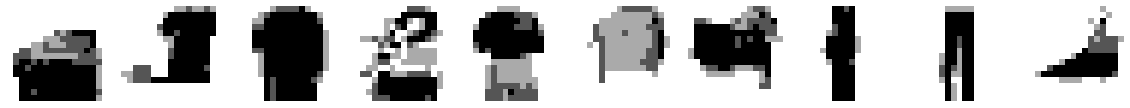

469/469 [==============================] - 26s 56ms/step - loss: 0.3492
Epoch 20/150
469/469 [==============================] - ETA: 0s - loss: 0.3486
Saved to ./output/generated_img_019.png


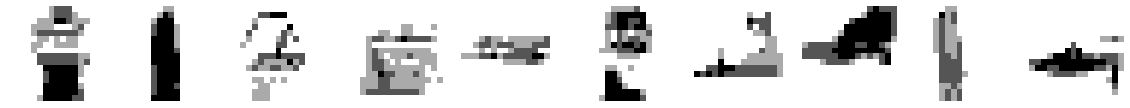

469/469 [==============================] - 27s 58ms/step - loss: 0.3486
Epoch 21/150
469/469 [==============================] - ETA: 0s - loss: 0.3478
Saved to ./output/generated_img_020.png


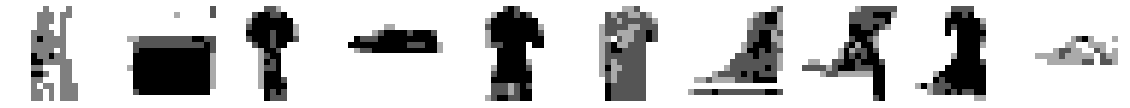

469/469 [==============================] - 26s 56ms/step - loss: 0.3478
Epoch 22/150
468/469 [============================>.] - ETA: 0s - loss: 0.3469
Saved to ./output/generated_img_021.png


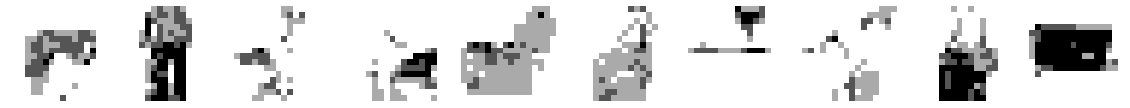

469/469 [==============================] - 28s 59ms/step - loss: 0.3469
Epoch 23/150
469/469 [==============================] - ETA: 0s - loss: 0.3459
Saved to ./output/generated_img_022.png


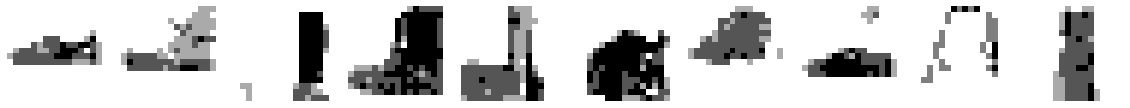

469/469 [==============================] - 26s 56ms/step - loss: 0.3459
Epoch 24/150
469/469 [==============================] - ETA: 0s - loss: 0.3454
Saved to ./output/generated_img_023.png


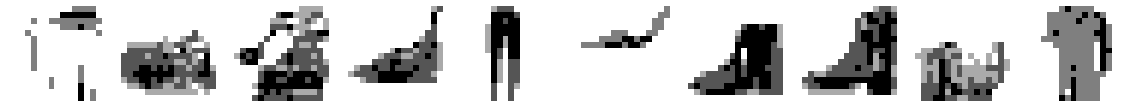

469/469 [==============================] - 28s 60ms/step - loss: 0.3454
Epoch 25/150
469/469 [==============================] - ETA: 0s - loss: 0.3448
Saved to ./output/generated_img_024.png


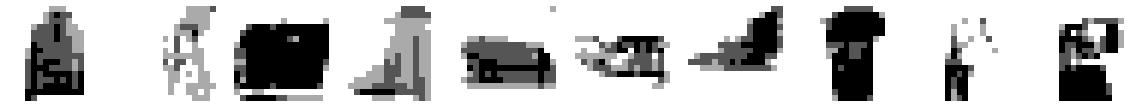

469/469 [==============================] - 26s 57ms/step - loss: 0.3448
Epoch 26/150
468/469 [============================>.] - ETA: 0s - loss: 0.3441
Saved to ./output/generated_img_025.png


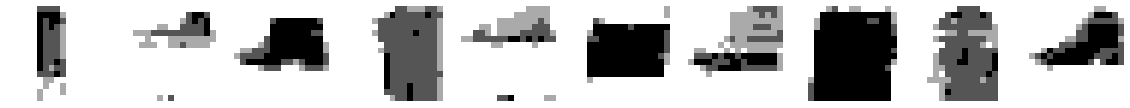

469/469 [==============================] - 26s 56ms/step - loss: 0.3441
Epoch 27/150
469/469 [==============================] - ETA: 0s - loss: 0.3434
Saved to ./output/generated_img_026.png


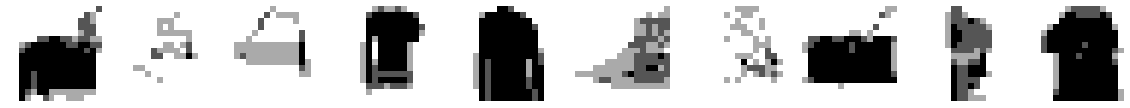

469/469 [==============================] - 26s 56ms/step - loss: 0.3434
Epoch 28/150
469/469 [==============================] - ETA: 0s - loss: 0.3430
Saved to ./output/generated_img_027.png


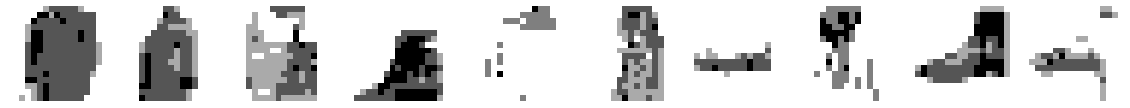

469/469 [==============================] - 27s 58ms/step - loss: 0.3430
Epoch 29/150
469/469 [==============================] - ETA: 0s - loss: 0.3423
Saved to ./output/generated_img_028.png


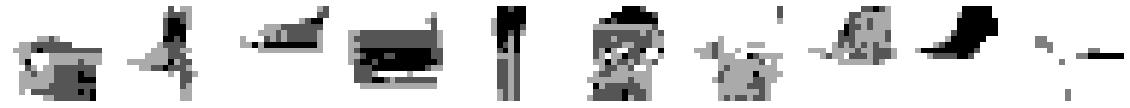

469/469 [==============================] - 27s 58ms/step - loss: 0.3423
Epoch 30/150
469/469 [==============================] - ETA: 0s - loss: 0.3418
Saved to ./output/generated_img_029.png


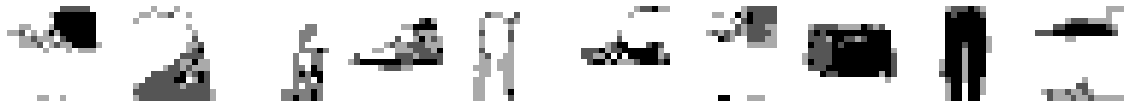

469/469 [==============================] - 28s 59ms/step - loss: 0.3418
Epoch 31/150
469/469 [==============================] - ETA: 0s - loss: 0.3413
Saved to ./output/generated_img_030.png


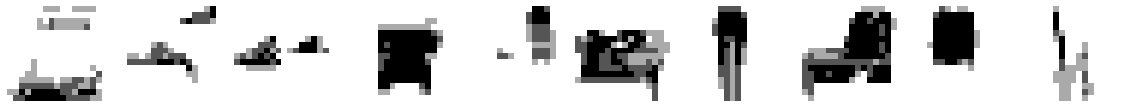

469/469 [==============================] - 29s 61ms/step - loss: 0.3413
Epoch 32/150
469/469 [==============================] - ETA: 0s - loss: 0.3409
Saved to ./output/generated_img_031.png


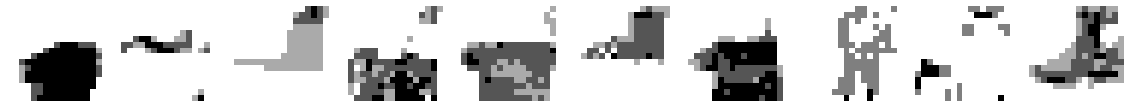

469/469 [==============================] - 29s 62ms/step - loss: 0.3409
Epoch 33/150
468/469 [============================>.] - ETA: 0s - loss: 0.3406
Saved to ./output/generated_img_032.png


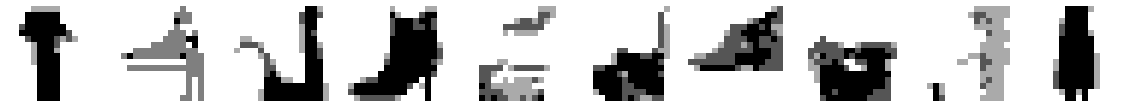

469/469 [==============================] - 30s 64ms/step - loss: 0.3406
Epoch 34/150
469/469 [==============================] - ETA: 0s - loss: 0.3399
Saved to ./output/generated_img_033.png


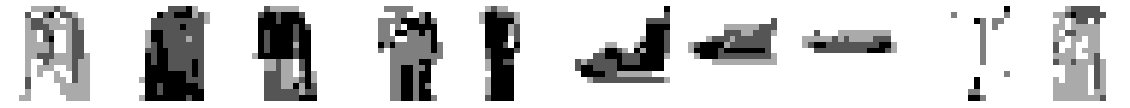

469/469 [==============================] - 28s 59ms/step - loss: 0.3399
Epoch 35/150
469/469 [==============================] - ETA: 0s - loss: 0.3396
Saved to ./output/generated_img_034.png


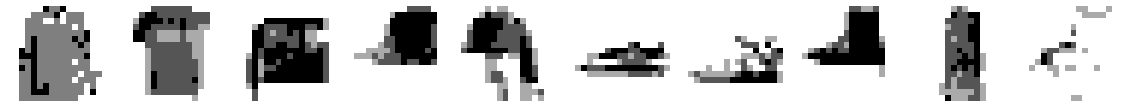

469/469 [==============================] - 29s 63ms/step - loss: 0.3396
Epoch 36/150
469/469 [==============================] - ETA: 0s - loss: 0.3391
Saved to ./output/generated_img_035.png


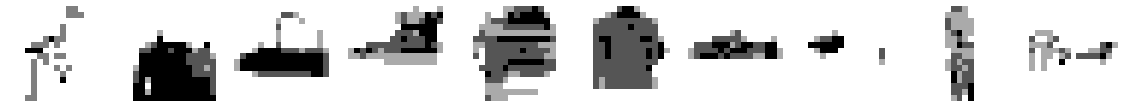

469/469 [==============================] - 28s 59ms/step - loss: 0.3391
Epoch 37/150
469/469 [==============================] - ETA: 0s - loss: 0.3387
Saved to ./output/generated_img_036.png


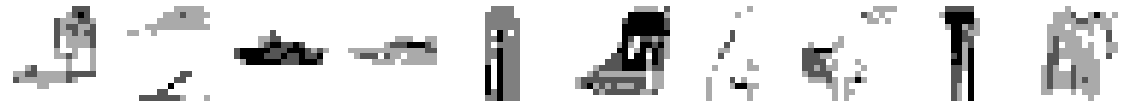

469/469 [==============================] - 30s 64ms/step - loss: 0.3387
Epoch 38/150
469/469 [==============================] - ETA: 0s - loss: 0.3387
Saved to ./output/generated_img_037.png


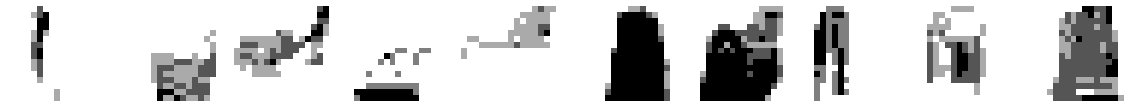

469/469 [==============================] - 29s 61ms/step - loss: 0.3387
Epoch 39/150
469/469 [==============================] - ETA: 0s - loss: 0.3378
Saved to ./output/generated_img_038.png


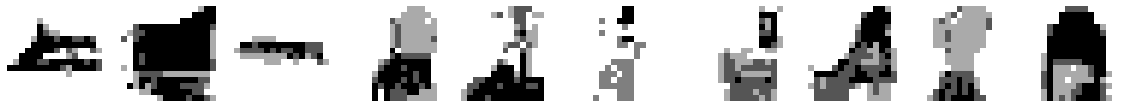

469/469 [==============================] - 30s 64ms/step - loss: 0.3378
Epoch 40/150
468/469 [============================>.] - ETA: 0s - loss: 0.3378
Saved to ./output/generated_img_039.png


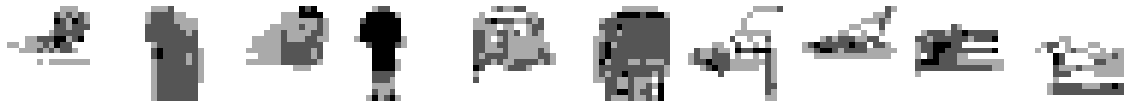

469/469 [==============================] - 28s 59ms/step - loss: 0.3378
Epoch 41/150
468/469 [============================>.] - ETA: 0s - loss: 0.3373
Saved to ./output/generated_img_040.png


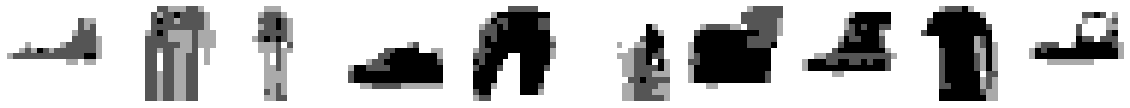

469/469 [==============================] - 30s 63ms/step - loss: 0.3373
Epoch 42/150
469/469 [==============================] - ETA: 0s - loss: 0.3372
Saved to ./output/generated_img_041.png


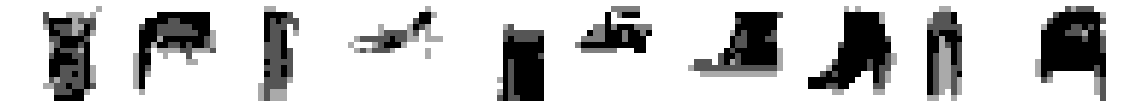

469/469 [==============================] - 28s 59ms/step - loss: 0.3372
Epoch 43/150
468/469 [============================>.] - ETA: 0s - loss: 0.3367
Saved to ./output/generated_img_042.png


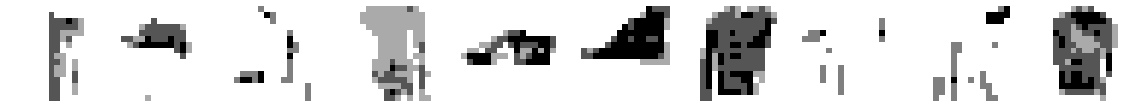

469/469 [==============================] - 27s 59ms/step - loss: 0.3367
Epoch 44/150
469/469 [==============================] - ETA: 0s - loss: 0.3365
Saved to ./output/generated_img_043.png


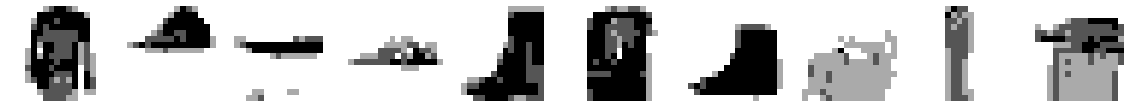

469/469 [==============================] - 28s 59ms/step - loss: 0.3365
Epoch 45/150
468/469 [============================>.] - ETA: 0s - loss: 0.3360
Saved to ./output/generated_img_044.png


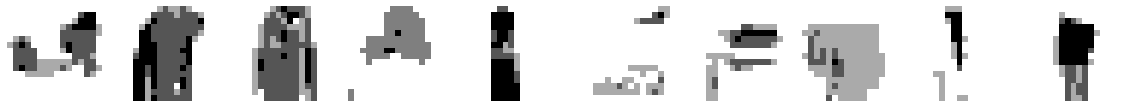

469/469 [==============================] - 28s 60ms/step - loss: 0.3360
Epoch 46/150
468/469 [============================>.] - ETA: 0s - loss: 0.3358
Saved to ./output/generated_img_045.png


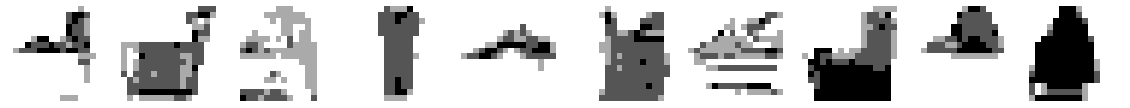

469/469 [==============================] - 28s 60ms/step - loss: 0.3358
Epoch 47/150
469/469 [==============================] - ETA: 0s - loss: 0.3355
Saved to ./output/generated_img_046.png


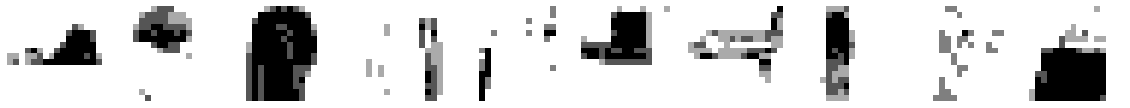

469/469 [==============================] - 28s 59ms/step - loss: 0.3355
Epoch 48/150
469/469 [==============================] - ETA: 0s - loss: 0.3352
Saved to ./output/generated_img_047.png


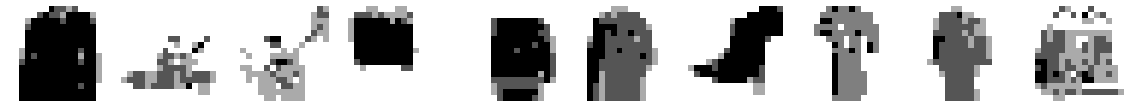

469/469 [==============================] - 28s 59ms/step - loss: 0.3352
Epoch 49/150
469/469 [==============================] - ETA: 0s - loss: 0.3352
Saved to ./output/generated_img_048.png


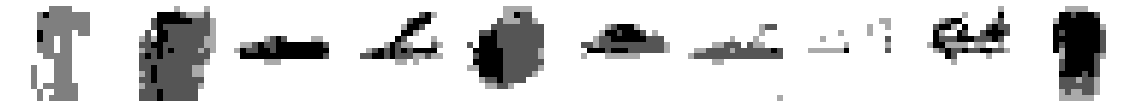

469/469 [==============================] - 28s 59ms/step - loss: 0.3352
Epoch 50/150
469/469 [==============================] - ETA: 0s - loss: 0.3347
Saved to ./output/generated_img_049.png


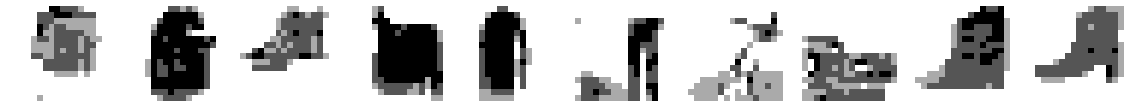

469/469 [==============================] - 28s 59ms/step - loss: 0.3347
Epoch 51/150
469/469 [==============================] - ETA: 0s - loss: 0.3345
Saved to ./output/generated_img_050.png


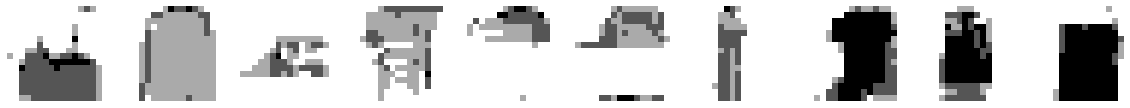

469/469 [==============================] - 27s 57ms/step - loss: 0.3345
Epoch 52/150
469/469 [==============================] - ETA: 0s - loss: 0.3343
Saved to ./output/generated_img_051.png


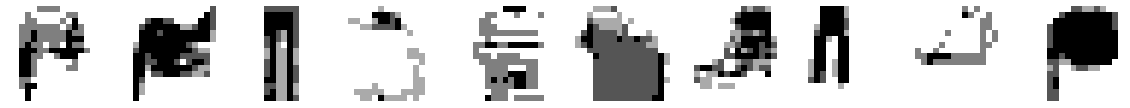

469/469 [==============================] - 28s 60ms/step - loss: 0.3343
Epoch 53/150
469/469 [==============================] - ETA: 0s - loss: 0.3339
Saved to ./output/generated_img_052.png


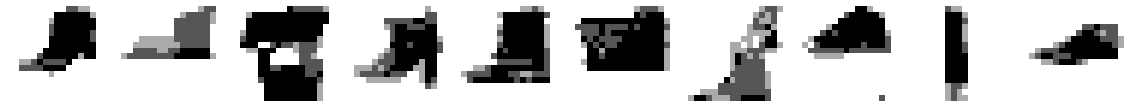

469/469 [==============================] - 27s 57ms/step - loss: 0.3339
Epoch 54/150
469/469 [==============================] - ETA: 0s - loss: 0.3337
Saved to ./output/generated_img_053.png


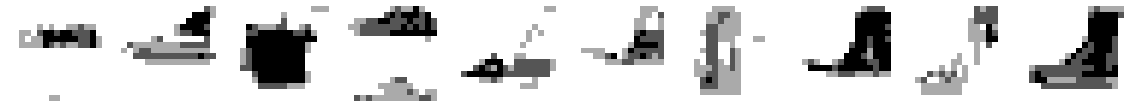

469/469 [==============================] - 29s 61ms/step - loss: 0.3337
Epoch 55/150
469/469 [==============================] - ETA: 0s - loss: 0.3335
Saved to ./output/generated_img_054.png


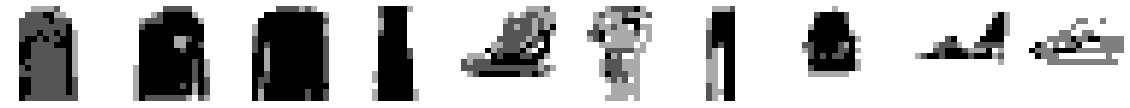

469/469 [==============================] - 27s 57ms/step - loss: 0.3335
Epoch 56/150
468/469 [============================>.] - ETA: 0s - loss: 0.3333
Saved to ./output/generated_img_055.png


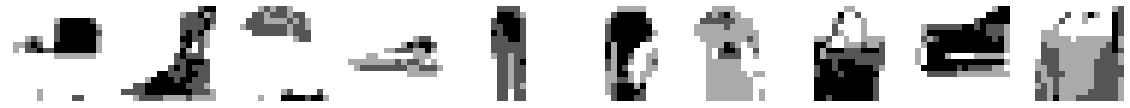

469/469 [==============================] - 26s 56ms/step - loss: 0.3333
Epoch 57/150
469/469 [==============================] - ETA: 0s - loss: 0.3330
Saved to ./output/generated_img_056.png


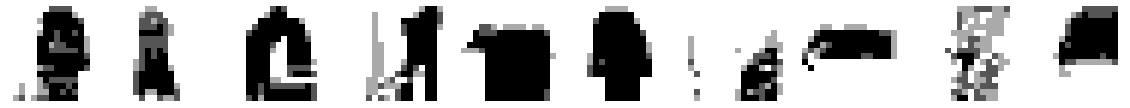

469/469 [==============================] - 27s 57ms/step - loss: 0.3330
Epoch 58/150
469/469 [==============================] - ETA: 0s - loss: 0.3329
Saved to ./output/generated_img_057.png


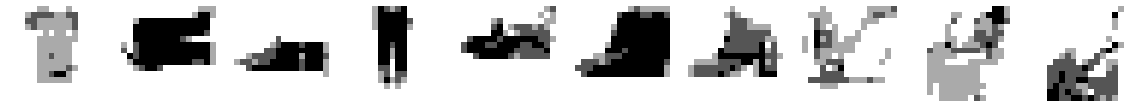

469/469 [==============================] - 27s 58ms/step - loss: 0.3329
Epoch 59/150
469/469 [==============================] - ETA: 0s - loss: 0.3328
Saved to ./output/generated_img_058.png


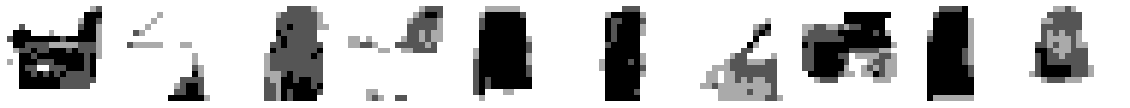

469/469 [==============================] - 27s 58ms/step - loss: 0.3328
Epoch 60/150
469/469 [==============================] - ETA: 0s - loss: 0.3326
Saved to ./output/generated_img_059.png


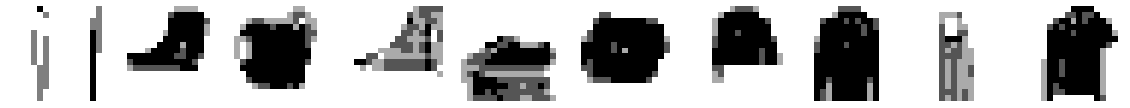

469/469 [==============================] - 27s 57ms/step - loss: 0.3326
Epoch 61/150
469/469 [==============================] - ETA: 0s - loss: 0.3321
Saved to ./output/generated_img_060.png


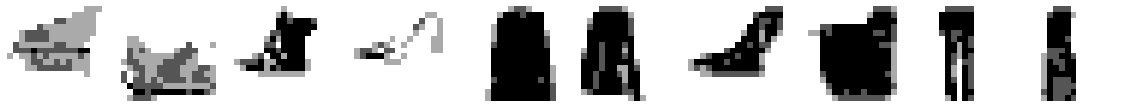

469/469 [==============================] - 27s 57ms/step - loss: 0.3321
Epoch 62/150
469/469 [==============================] - ETA: 0s - loss: 0.3321
Saved to ./output/generated_img_061.png


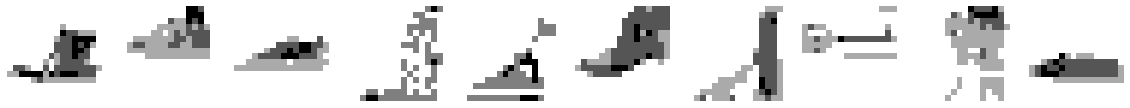

469/469 [==============================] - 27s 58ms/step - loss: 0.3321
Epoch 63/150
469/469 [==============================] - ETA: 0s - loss: 0.3318
Saved to ./output/generated_img_062.png


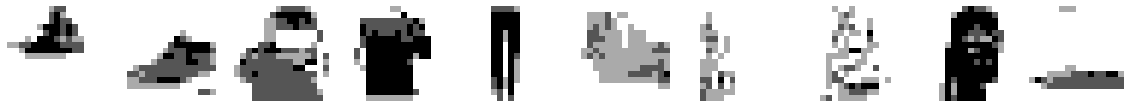

469/469 [==============================] - 28s 60ms/step - loss: 0.3318
Epoch 64/150
469/469 [==============================] - ETA: 0s - loss: 0.3318
Saved to ./output/generated_img_063.png


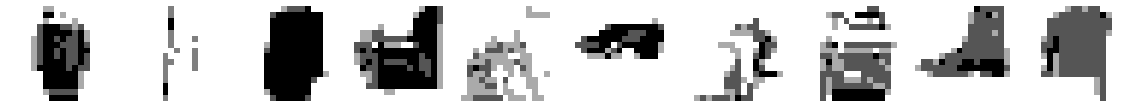

469/469 [==============================] - 27s 57ms/step - loss: 0.3318
Epoch 65/150
469/469 [==============================] - ETA: 0s - loss: 0.3317
Saved to ./output/generated_img_064.png


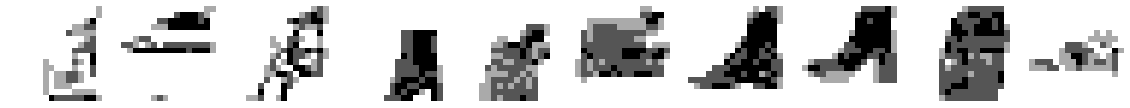

469/469 [==============================] - 28s 59ms/step - loss: 0.3317
Epoch 66/150
469/469 [==============================] - ETA: 0s - loss: 0.3313
Saved to ./output/generated_img_065.png


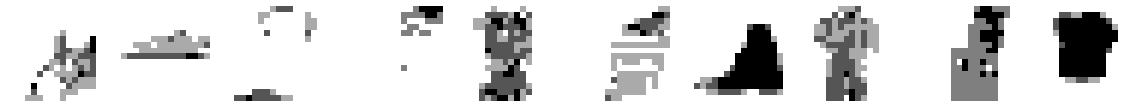

469/469 [==============================] - 27s 57ms/step - loss: 0.3313
Epoch 67/150
469/469 [==============================] - ETA: 0s - loss: 0.3311
Saved to ./output/generated_img_066.png


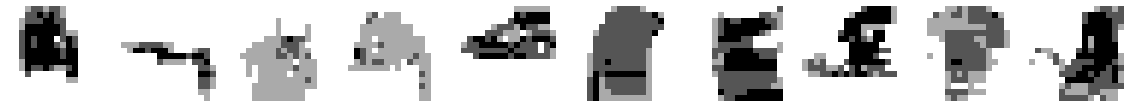

469/469 [==============================] - 27s 57ms/step - loss: 0.3311
Epoch 68/150
469/469 [==============================] - ETA: 0s - loss: 0.3309
Saved to ./output/generated_img_067.png


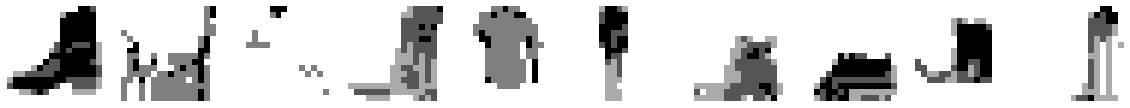

469/469 [==============================] - 27s 57ms/step - loss: 0.3309
Epoch 69/150
469/469 [==============================] - ETA: 0s - loss: 0.3309
Saved to ./output/generated_img_068.png


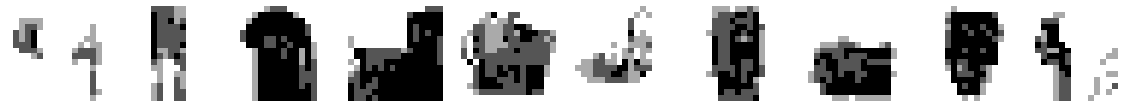

469/469 [==============================] - 26s 56ms/step - loss: 0.3309
Epoch 70/150
469/469 [==============================] - ETA: 0s - loss: 0.3308
Saved to ./output/generated_img_069.png


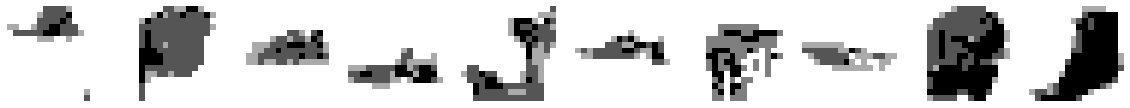

469/469 [==============================] - 27s 57ms/step - loss: 0.3308
Epoch 71/150
469/469 [==============================] - ETA: 0s - loss: 0.3304
Saved to ./output/generated_img_070.png


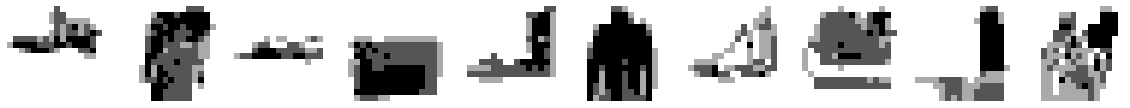

469/469 [==============================] - 27s 57ms/step - loss: 0.3304
Epoch 72/150
469/469 [==============================] - ETA: 0s - loss: 0.3302
Saved to ./output/generated_img_071.png


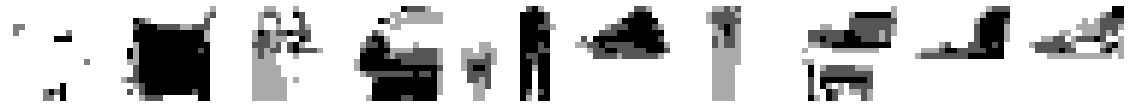

469/469 [==============================] - 28s 59ms/step - loss: 0.3302
Epoch 73/150
469/469 [==============================] - ETA: 0s - loss: 0.3302
Saved to ./output/generated_img_072.png


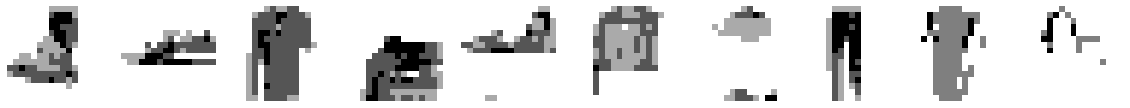

469/469 [==============================] - 26s 56ms/step - loss: 0.3302
Epoch 74/150
469/469 [==============================] - ETA: 0s - loss: 0.3299
Saved to ./output/generated_img_073.png


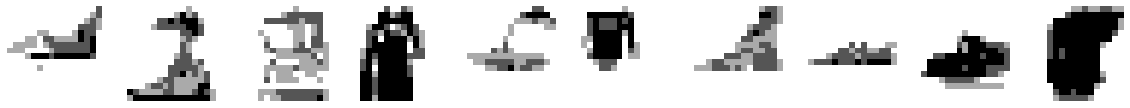

469/469 [==============================] - 28s 59ms/step - loss: 0.3299
Epoch 75/150
469/469 [==============================] - ETA: 0s - loss: 0.3299
Saved to ./output/generated_img_074.png


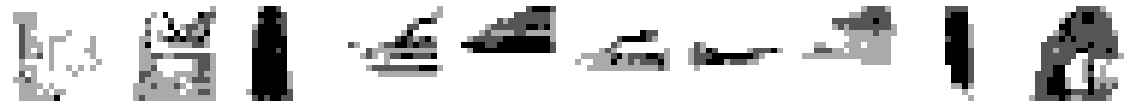

469/469 [==============================] - 27s 57ms/step - loss: 0.3299
Epoch 76/150
469/469 [==============================] - ETA: 0s - loss: 0.3297
Saved to ./output/generated_img_075.png


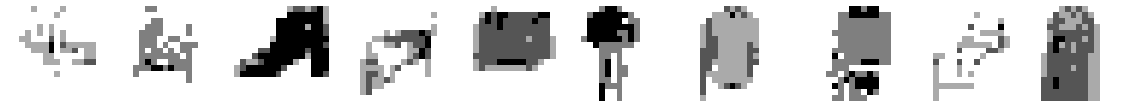

469/469 [==============================] - 26s 56ms/step - loss: 0.3297
Epoch 77/150
469/469 [==============================] - ETA: 0s - loss: 0.3295
Saved to ./output/generated_img_076.png


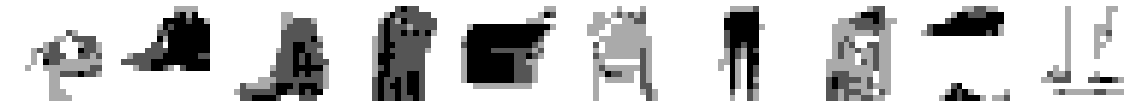

469/469 [==============================] - 27s 57ms/step - loss: 0.3295
Epoch 78/150
469/469 [==============================] - ETA: 0s - loss: 0.3295
Saved to ./output/generated_img_077.png


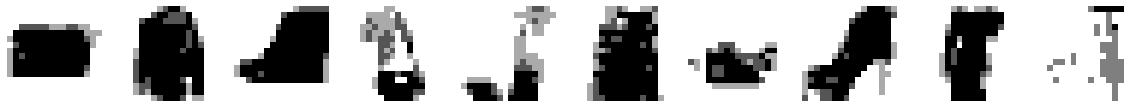

469/469 [==============================] - 26s 56ms/step - loss: 0.3295
Epoch 79/150
469/469 [==============================] - ETA: 0s - loss: 0.3293
Saved to ./output/generated_img_078.png


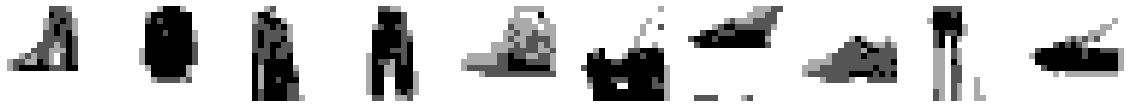

469/469 [==============================] - 27s 57ms/step - loss: 0.3293
Epoch 80/150
469/469 [==============================] - ETA: 0s - loss: 0.3293
Saved to ./output/generated_img_079.png


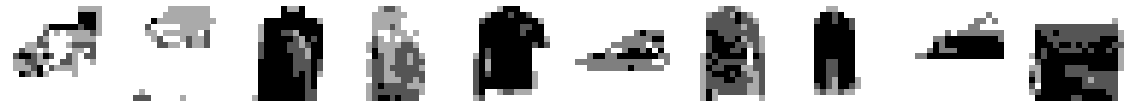

469/469 [==============================] - 26s 56ms/step - loss: 0.3293
Epoch 81/150
469/469 [==============================] - ETA: 0s - loss: 0.3290
Saved to ./output/generated_img_080.png


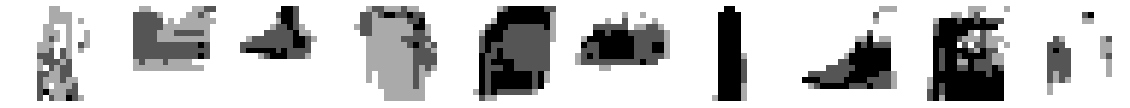

469/469 [==============================] - 28s 59ms/step - loss: 0.3290
Epoch 82/150
469/469 [==============================] - ETA: 0s - loss: 0.3288
Saved to ./output/generated_img_081.png


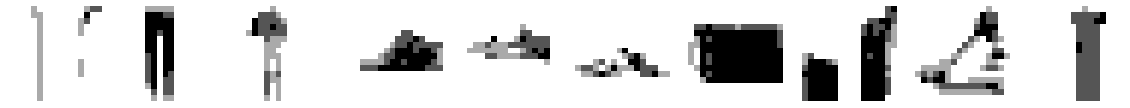

469/469 [==============================] - 26s 56ms/step - loss: 0.3288
Epoch 83/150
469/469 [==============================] - ETA: 0s - loss: 0.3288

KeyboardInterrupt: 

In [66]:
pixel_cnn.fit(
    input_data,
    output_data,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[tensorboard_callback, img_generator_callback],
)

## 4. Generate images <a name="generate"></a>

In [75]:
generated_images = img_generator_callback.generate(temperature=1.0)

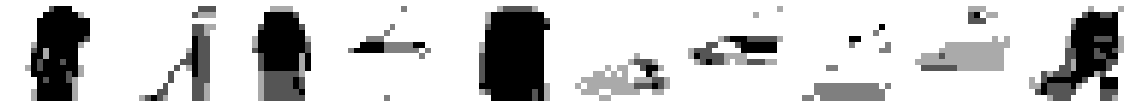

In [76]:
display(generated_images)